In [55]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from iprocessor import add_day_name_column, add_date_name_column, smooth_sundays_rolling_w7_l

#### the python script iprocessor, smoothes the data by implementing moving average

## there is need for 
- parameters
- initialization for the compartments

In [56]:
# Sample parameters,
#contacts = 2.0
transmission_prob = 0.3649
reducing_transmission = 0.764
exposed_period = 5.2  #
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 11  # 11,23
prob_asymptomatic = 0.2
prob_quarant_inf = 0.05
test_asy = 0.171
dev_symp = 0.125
mortality_isolated = 0.002
mortality_infected = 0.01

In [57]:
total_population = 82_000_000  # Total number of individuals
E0 = 2026.25
A0 = 3798
I0 = 376.4
F0 = 2255
R0 = 170204
D0 = 9060
S0 = total_population - E0 - A0 - I0 - F0 - R0 - D0
initial_conditions = [S0, E0, A0, I0, F0, R0, D0]

### Dataframe

In [58]:
df = pd.read_csv(r'German_case_period_may_aug.csv')

In [59]:
#Convert 'Date' column to datetime format----------------------------------------------------------------------
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Modification------------------------------------------------------------------------------
# Add the 'days' column
df = add_day_name_column(df)
df = add_date_name_column(df)
# second modification with w7_l-----------------------------------------------------------------------------
df_observed = smooth_sundays_rolling_w7_l(df)
df_observed
# -----------------------------------------------------------------------------------------------------

,Date,Confirmed,Deaths,Recovered,n_confirmed,n_death,n_recovered,Infection_case,date_name,days,rolling_mean_r,rolling_mean_c,rolling_mean_d
0,2020-05-01,166468,8602,157866,428.333333,16.000000,412.333333,915,Friday,1,412.333333,428.333333,16.000000
1,2020-05-02,167160,8626,158534,529.250000,22.750000,506.500000,846,Saturday,2,506.500000,529.250000,22.750000
2,2020-05-03,167753,8650,159103,602.600000,25.800000,576.800000,805,Sunday,3,576.800000,602.600000,25.800000
3,2020-05-04,168585,8693,159892,654.666667,25.833333,628.833333,607,Monday,4,628.833333,654.666667,25.833333
4,2020-05-05,169481,8731,160750,682.000000,27.285714,654.714286,447,Tuesday,5,654.714286,682.000000,27.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2020-07-28,210338,9412,200926,679.285714,4.285714,675.000000,563,Tuesday,89,675.000000,679.285714,4.285714
89,2020-07-29,211114,9418,201696,694.000000,6.000000,688.000000,919,Wednesday,90,688.000000,694.000000,6.000000
90,2020-07-30,211868,9423,202445,709.285714,5.714286,703.571429,940,Thursday,91,703.571429,709.285714,5.714286
91,2020-07-31,212712,9438,203274,749.833333,6.000000,743.833333,996,Friday,92,743.833333,749.833333,6.000000


In [80]:
# Taking 'days' time column from dataframe
t_fit = np.array(df_observed['days'])
#tmax_base = len(t_fit_base)
tmax = max(t_fit)
t = np.linspace(0,tmax,tmax*2)# 0.5 days maybe
array_dead = np.array(df_observed['n_death'])

### derivative equation for the flowchart

In [61]:
def derivative_rhs(t, initial_conditions, contacts, transmission_prob, total_population, reducing_transmission,
                   exposed_period, asymptomatic_period, infectious_period, isolated_period,
                   prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    S, E, A, I, F, R, D = initial_conditions
    derivS = - contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population
    derivE = contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population - E / exposed_period
    derivA = prob_asymptomatic * E / exposed_period - A / asymptomatic_period
    derivI = (
                         1 - prob_asymptomatic) * E / exposed_period + dev_symp * A / asymptomatic_period - I / infectious_period  # +
    derivF = prob_quarant_inf * I / infectious_period - F / isolated_period + test_asy * A / asymptomatic_period  # prob_isolated_asy*A/asymptomatic_period
    derivR = (1 - prob_quarant_inf - mortality_infected) * I / infectious_period + (
                1 - mortality_isolated) * F / isolated_period + (
                         1 - dev_symp - test_asy) * A / asymptomatic_period  # (1-prob_isolated_asy)*A / asymptomatic_period
    derivD = (mortality_infected) * I / infectious_period + mortality_isolated * F / isolated_period
    return np.array([derivS, derivE, derivA, derivI, derivF, derivR, derivD])

In [104]:
def seaifrd_model(t, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                  exposed_period, asymptomatic_period, infectious_period, isolated_period,
                  prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected):
    def derivative(t, initial_conditions):
        return derivative_rhs(t, initial_conditions, contacts, transmission_prob, total_population,
                              reducing_transmission,
                              exposed_period, asymptomatic_period, infectious_period,
                              isolated_period, prob_asymptomatic,
                              prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    solution = solve_ivp(derivative, [0, tmax], y0=initial_conditions, method='RK45',t_eval=t)#t_eval=x[:,0]
    #print(solution)
    return solution  # .y.flatten()

In [105]:
def objective_function_recoverd_dead(t,isolated_period):

    # Model parameters (could be passed as arguments or fixed here)
    contacts = 2
    transmission_prob = 0.3
    total_population = 82000000
    reducing_transmission = 0.55
    exposed_period = 5.2
    asymptomatic_period = 7
    infectious_period = 3.7
    #isolated_period = 12
    prob_asymptomatic = 0.34
    prob_quarant_inf = 0.9303
    test_asy = 0.271
    dev_symp = 0.125
    mortality_isolated = 0.02
    mortality_infected = 0.1

    # Solve the model
    #sorted(set(t))
    solution = seaifrd_model(t, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                             exposed_period, asymptomatic_period, infectious_period, isolated_period,
                             prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    #print(solution)
    recovered = solution.y[5]
    
    return recovered


In [157]:
def objective_function_dead(t,contacts):
    
    # Model parameters (could be passed as arguments or fixed here)
    #contacts = 2
    transmission_prob = 0.3
    total_population = 82000000
    reducing_transmission = 0.55
    exposed_period = 5.2
    asymptomatic_period = 7
    infectious_period = 3.7
    isolated_period = 12
    prob_asymptomatic = 0.34
    prob_quarant_inf = 0.9303
    test_asy = 0.271
    dev_symp = 0.125
    mortality_isolated = 0.02
    mortality_infected = 0.1

    # Solve the model
    #sorted(set(t))
    solution = seaifrd_model(t, contacts, initial_conditions, transmission_prob, total_population, reducing_transmission,
                             exposed_period, asymptomatic_period, infectious_period, isolated_period,
                             prob_asymptomatic, prob_quarant_inf, test_asy, dev_symp, mortality_isolated, mortality_infected)

    #print(solution)
    #dead = solution.y[6]
    

    return solution.y[5]


In [158]:
### Calling curve_fit Function

In [159]:
#t_end = df_observed['days'].iloc[-1]
#print(f't_end = {(t_end)}, t_fit = {len(t_fit)}')
# Create a sequence from 0 to t_end
#t_fit = np.arange(0, 2*tmax, 1)

popt, pcov = curve_fit(objective_function_dead, t_fit, array_dead)


In [160]:
popt

array([-794.30992834])

In [161]:
perr_r_d = np.sqrt(np.diag(pcov))
perr_r_d

array([925520.22618997])

In [162]:
### regarding for the curve_fitting; do we need to find the first derivation for the data for the dead and recovered before 
#  we apply curve fit?

In [163]:
y_ = objective_function_dead(t,contacts)

y_[:190]

array([170698.59662193, 170790.86621406, 170882.49731404, 170973.57631989,
       171064.18923501, 171154.421881  , 171244.35869779, 171334.08274116,
       171423.67568265, 171513.21780959, 171602.78802513, 171692.46384818,
       171782.32141347, 171872.43547152, 171962.87938864, 172053.72699269,
       172145.05486217, 172236.93493343, 172329.43838488, 172422.63590393,
       172516.59768698, 172611.39343946, 172707.09237577, 172803.76321933,
       172901.47420256, 173000.29306688, 173100.2870627 , 173201.52294945,
       173304.06699555, 173407.98497842, 173513.34350359, 173620.21436948,
       173728.66214976, 173838.75060751, 173950.54398277, 174064.10699247,
       174179.50483044, 174296.80316744, 174416.0681511 , 174537.36640601,
       174660.76503363, 174786.33161234, 174914.13419743, 175044.24132109,
       175176.72199244, 175311.64569749, 175449.08239915, 175589.10253726,
       175731.77702856, 175877.1772667 , 176025.37512223, 176176.44588586,
       176330.47514561, 1

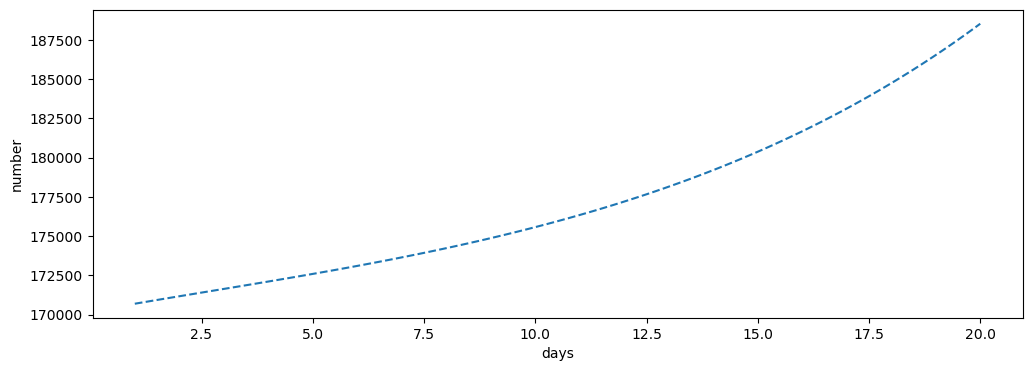

In [164]:
t= np.linspace(1,20,100)

fig, ax = plt.subplots(1,1, figsize=(12,4))
plt.plot(t,y_[:100],'--')
ax.set_xlabel('days')
ax.set_ylabel('number')
plt.show()

In [146]:
y_0 = y_[0:]
y_0.shape

(186,)